In [1]:
#importing dependencies

#importing Opencv for preprocessing
import cv2

#importing Dlib for face detction and face alignment
import dlib

#importing numpy for doing mathematical operation
import numpy as np

#importing load_model function from model module to load our saved model
from keras.models import load_model

#importing matplotlib for seeing input and output image
import matplotlib.pyplot as plt

#importing scipy for calculating the similarity between images
from scipy import spatial

#loading trained model on images
model = load_model('facenet_keras.h5')

#creating dlib detector to detct face from input image
detector = dlib.get_frontal_face_detector()

#creaeting dlib predcitor to predcit 68 landmarks of input image and then aligning images
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

#image path which is to be searched in database
image_path, image_name = 'Test Images/153.jpg', 153

Using TensorFlow backend.
c:\users\rishi sharma\appdata\local\programs\python\python36\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:
#required function for doing facial recignition and face alignment

#function to input in image, do it's alignment then return 128D embedding which contain important features about image which determines it's identity
def extract_face_and_get_embedding(filename, required_size, model, i):
    
    #taking in input image and changing it to RGB format as in OpenCv it is in BGR format
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #detecting face from input image
    dets = detector(img, 3)

    
    #counting number of faces in image because if there are no faces then no need to go further
    num_faces = len(dets)

    #if number of faces == 0 no face found is the output message else we will go further for computation
    if num_faces == 0:

        print("Sorry, there were no faces found in image ", i)

    elif num_faces == 1:

        faces = dlib.full_object_detections()

        #predicting landmarks of detected face from input image
        for detection in dets:
            faces.append(predictor(img, detection))

        #aligning image to get better accuracy while comparing 2 images
        #We can play with padding to zoom-in and out to get required image
        image = dlib.get_face_chips(img, faces, size = required_size, padding = 0.2)

        #converting image to numpy array
        image = np.array(image)

        #reshaping image to 3D array as output of dlib predictor is 4D array of form 1 x required_size x required_size x 3
        image = image.reshape(required_size, required_size, 3)
        face_pixels = image.astype('float32')

        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std

        samples = np.expand_dims(face_pixels, axis=0)

        #predicting the ouput 128D embedding for input image
        yhat = model.predict(samples)

        return yhat[0]
    
    else:
        
        print('More than one number of faces found in image')

#function for comparing images in database and predicting top n similar images from database
def who_it_is(path_of_image, database, model, i):
    
    #storing similarity distance in dictionary 'similarity_distance' while storing name as well as distance in list 'list_of_similarity' for later sorting on basis of distance
    similarity_distance, list_of_similarity = {}, []
    
    #getting 128D encoding of input image from our trained model which includes important features, identity as well as important information about input image
    encoding = extract_face_and_get_embedding(path_of_image, 160, model, i)
    
    #initializing min_dist with some random larger number
    min_dist = 10
    
    #if no face is found in image than we are returning flag 1 and None which will tell us that in later function that there is no face in input image
    if encoding is None:
        list_of_similarity.append((1, None))
        return None, list_of_similarity
    
    #if face is found then we are doing furthur computation
    else:
        
        #searching throughout database and comparing with each image in database
        for (name, db_enc) in database.items():
            
            #if there is image in database where our model is not able to detect any face we are ignoring that image
            if db_enc is not None:

                #calculating similarity distance between images
                dist = spatial.distance.cosine(db_enc, encoding)
                
                #storing distance for later use
                similarity_distance[name] = dist

                list_of_similarity.append((dist, name))

                #storing image of minimum distacne in the database
                if dist < min_dist:

                    min_dist = dist
                    identity = name

        #returning similarity distance(a dictonary)
        return similarity_distance, list_of_similarity

#function to show top n similar image as well as input image and their similarity distances with their name in database
def output(image_path, similarity_distance, list_of_similarity, number_of_images_to_show):
    
    #showing input image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title('Input Image')
    plt.show()
    
    if len(list_of_similarity) >= 2 :

        #sorting similarity in ascending order to take out top n minimum similarity distances
        list_of_similarity.sort()
        print('\n\n')
        #showing best n similar images found from databse
        print('TOP '+str(number_of_images_to_show)+' BEST IMAGES FOUND FROM DATABASE ARE :-----')
        for i in range(number_of_images_to_show):
            print('\n\n')
            print('Similar Image '+str(i+1)+' found is: '+str(list_of_similarity[i][1])+'.jpg with similarity '+str(round(list_of_similarity[i][0], 2)))
            plt.imshow(cv2.cvtColor(cv2.imread('Database/'+str(list_of_similarity[i][1])+'.jpg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print('\n\n')
            
    else:
        print('Sorry!, No face found in image')

In [32]:
%%time
#creating embeddings of all the images in database and storing in variable 'database' to save at the time of 
#outputing the images otherwise it will take around 15 min for giving output of each image beacause it has to calculate 
#embedding each time of whole database.

database = {}
for i in range(169):
    database[i+1] = extract_face_and_get_embedding('Database/'+str(i+1)+'.jpg', 160, model, i+1)

Sorry, there were no faces found in image  10
Sorry, there were no faces found in image  26
Sorry, there were no faces found in image  33
Sorry, there were no faces found in image  41
Sorry, there were no faces found in image  58
Sorry, there were no faces found in image  90
Sorry, there were no faces found in image  96
Sorry, there were no faces found in image  125
Sorry, there were no faces found in image  144
Wall time: 4min 53s


Sorry, there were no faces found in image  122


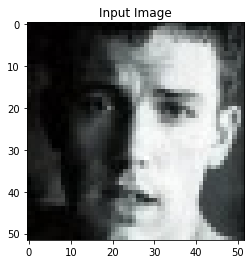

Sorry!, No face found in image


In [33]:
#predicting top n images found similar to input image
output(image_path, *who_it_is(image_path, database, model, image_name), 4)

In [14]:
for i in range(1, 119):
    image_path, image_name = 'Test Images/'+str(i)+'.jpg', i
    output(image_path, *who_it_is(image_path, database, model, image_name), 2)
    print('\n\n')